<img src="../Images/exchangeflow.jpg" align="right" style="width: 500px;">

# Estuarine Circulation

In an estuary freshwater input from land and salt water input from the ocean setup a salinity gradient that drives a residual circulation, with saltier water flowing into the estuary at the bottom and fresher water flowing out of the estuary at the surface

Here you will examine velocity as a function of depth and time to see how tides and salinity gradients influence this residual circulation. In the following steps you will

* Load model data
* Examine velocities and see how averaging allows insight into the circulation pattern
* Compare to tidal water levels to observe differences in Neap and Spring tides
* Compare with salinity profiles to determine the influence of 
stratification.

Below, the initial analysis is started, fill in where directions indicate.

In [2]:
# First we import the packages we want to use, note we must install netcdf4
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os

In [3]:
# set the location of our data
data_fol = '../Datasets'

# Uncomment and adjust as neccssary to work with Google drive
#!pip install netcdf4
#from google.colab import drive
#import os
#drive.mount('/content/drive')
#os.chdir('/content/drive/My Drive/YourWorkingFolder')
#data_fol = ''

In [4]:
# Loading and pre-processing model predictions from south Admiratly Inlet

# Choose a location to load
fname = 'admiralty.nc'

# Now use xarray to open the netcdf dataset
ds = xr.open_dataset(data_fol + '/' + fname)

# We are going to transpose two variables so that plots show time on x-axis
ds = ds.transpose('s_rho', 'ocean_time', 's_w', 'scalar')

# We will also set the s_rho dimension, which is the model layer, to the mean depth.
#  this will make it more intuitive we examine the modeled variables
ds['s_rho']=ds['z_rho'].mean(dim='ocean_time')
ds['s_rho'].attrs = {'long_name': 'Elevation', 'units': 'm'}

First let us plot the velocities. They are save in two variables, one for velocity northward, v, and one for velocity eastward, u. We will plot these velocities as a function of depth (y-axis) and time (x-axis) for a single month in summer.

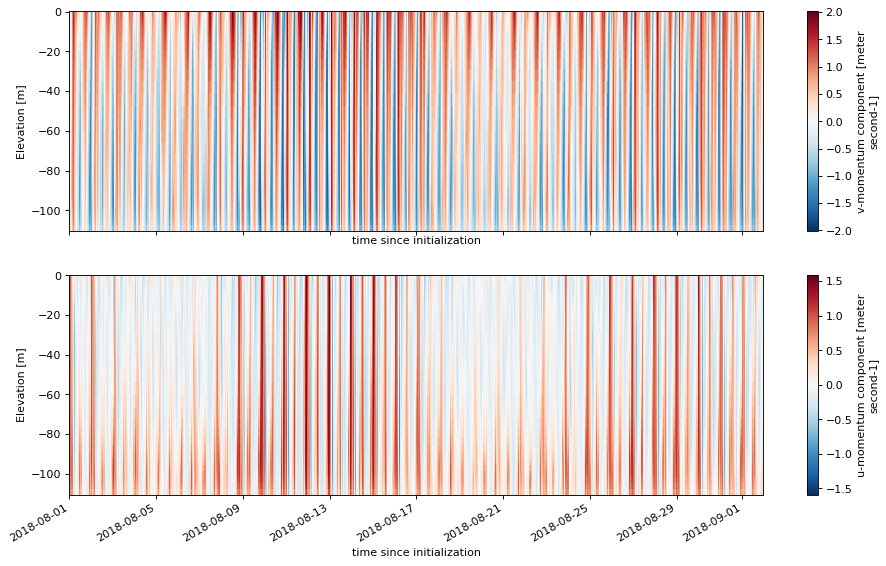

In [5]:
# In summer-time tides will have a larger influence, so plotting summer below.
# Note, red is velocity northward, blue is velocity southward
sdate = '2018-08-01'
edate = '2018-09-01'
v_sum = ds['v'].sel(ocean_time=slice(sdate,edate))
u_sum = ds['u'].sel(ocean_time=slice(sdate,edate))


f = plt.figure(num=None, figsize=(14,8), dpi=80, facecolor='w', edgecolor='k')
(ax1, ax2) = f.subplots(2, 1, sharex=True)
plt.sca(ax1)
v_sum.plot()
plt.sca(ax2)
u_sum.plot()

Looking at the plot above you see many stripes of red and blue, indicating the water flowing in and out on each tide during the month. The velocities are stronger in the north-south directions (notice the color-scale limits) because admiralty inlet is primarily orientied in the the north-south direction. 

What you don't see here is the pattern we were expecting, of surface waters flowing out (northward, red) and bottom waters flowing to the estuary (southward, blue). This is because the tidal action is much stronger than the residual flow. We need to do some averaging in time to get a better idea of what is happening on over the long-term mean.

To do this we create an averaging function below that use some filtering methods to remove the tidal signal.

In [6]:
# filter out the tidal fluxes and estimate the exchange flow, and then see if you can identify an pattern of exchange flow strength with Spring and Neap tidal cycles. Here you will
# To average out the tides we will use a filter defined below
# The details are not important, but just know this will remove the high frequency tidal motions, leaving residual flow
# Below we define a function to do the filtering
import numpy as np
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

No let us apply this averaging filter, butter_lowpass_filter to the velocities we plotted above in the north-south direction (v). Note that we do so using a loop for each depth layer, s_rho. 

In [9]:
# We will filter each model depth layer in a loop and construct a new fitlered variable, v_f
v_f = np.zeros(ds['u'].data.shape)
for i in range(ds['s_rho'].data.size):
  v_f[i,:] = butter_lowpass_filter(ds['v'].isel(s_rho=i).data,1/80,1,2)

ds['v_f'] = (['s_rho','ocean_time'],v_f) #New filtered variable
ds['v_f'].attrs = {'long_name': 'Averaged Velocity', 'units': 'm/s'}

Let us now plot the original velocities on top, and the filtered velocities on the bottom. Now do we see the two layer flow that we were expecting?

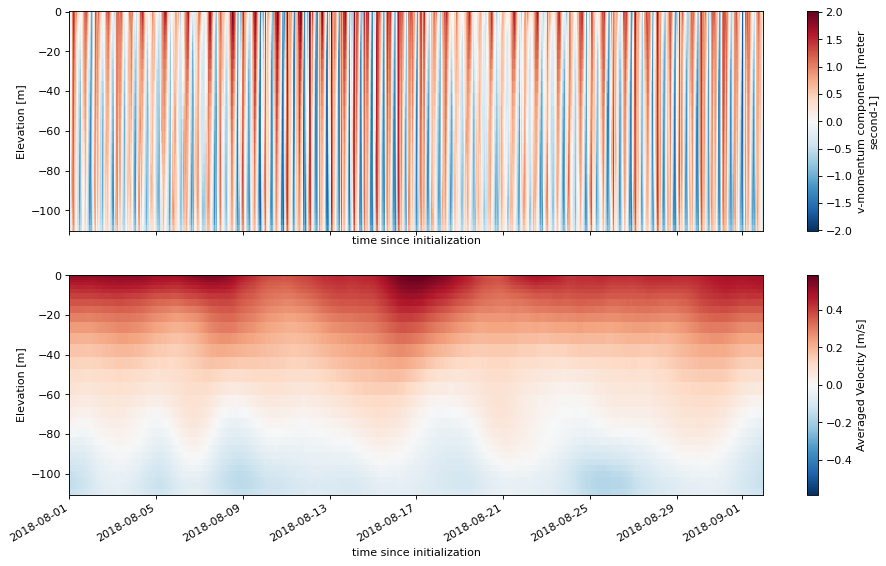

In [10]:
# Plotting the original and averaged velocity
v_sum = ds['v'].sel(ocean_time=slice(sdate,edate))
v_f_sum = ds['v_f'].sel(ocean_time=slice(sdate,edate))

f = plt.figure(num=None, figsize=(14,8), dpi=80, facecolor='w', edgecolor='k')
(ax1, ax2) = f.subplots(2, 1, sharex=True)
plt.sca(ax1)
v_sum.plot()
plt.sca(ax2)
v_f_sum.plot()

### Task 1 - Influence of tides

With your partner or in a small group decide on an answer to the following question. Put your response in the box below

*Do large tides drive a stronger or weaker exchange flow? Or do tides have no effect at all? And why?*

Your answer here

Now, let's see what the data says. Below, add code below to add zeta in the second panel. zeta is the free-surface, which is the tidal water level. zeta is a variable in your ds dataset you can access by using the ds['zeta'].

**Note the addition of add_colorbar=False to the plotting command. Without this addition the x-axes won't line up.*

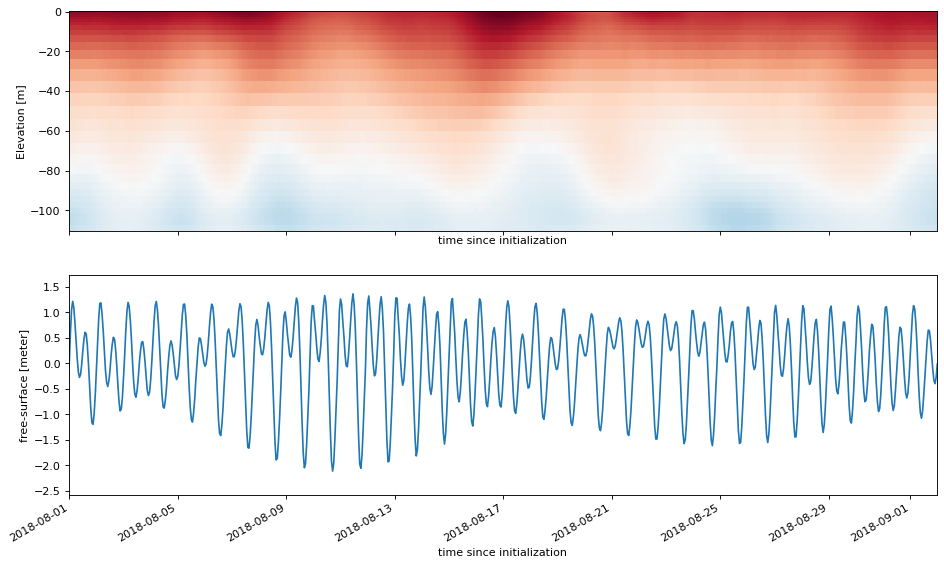

In [15]:
f = plt.figure(num=None, figsize=(14,8), dpi=80, facecolor='w', edgecolor='k')
(ax1, ax2) = f.subplots(2, 1, sharex=True)
plt.sca(ax1)
v_f_sum.plot(add_colorbar=False) # Note, removes colorbar to axes line up
plt.sca(ax2)
# insert your code here

# This is the solution, remove before providing to students!
ds['zeta'].plot() 


Looking at the plots you made above, when do you see the strongest surface velocities? Is it during Neap tide or Spring tide? Note there appears to be no pattern in the bottom velocities (blue). Things are messy in the real world, and don't always work as our simple schematics illustrate.

Now, that you've seen the data at Admiralty Inlet, go back to your initial answer and change or refine it based on what you see in the data.

Your answer here

### Task 2 - Influence of vertical salinity gradients

The results from above may seem a little unintutitive so to gain additional insight into what is happening let's look at the salinity structure. To do this let's first make a new variable for summer salinity and plot


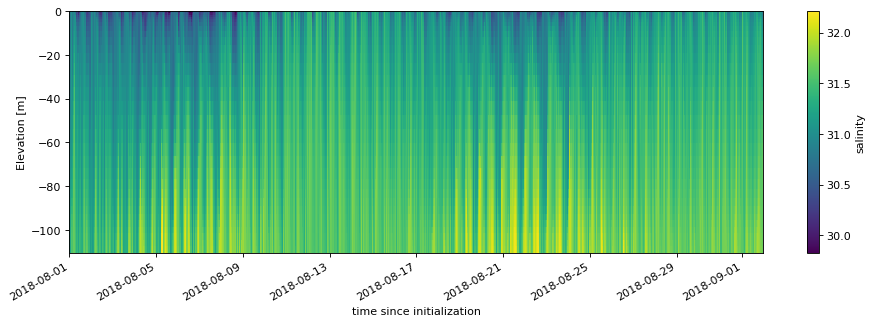

In [20]:
# Plot summer salinity
salt_sum = ds['salt'].sel(ocean_time=slice(sdate,edate))
f = plt.figure(num=None, figsize=(14,4), dpi=80, facecolor='w', edgecolor='k')
salt_sum.plot()

Looking at the above figure you see the salinity ranges form aroudn 30-32 psu (practical salinity units). At what times do you see the strongest vertical gradients in salinity? These periods correspond to times when the water is most strongly stratified. With your partner or group think about the following questions.


1. *How does tidal action influences stratification, do larger tides create more or less stratification? And Why?*
2. *How does stratification impact the estuary exchange circulation, do more highly stratified waters result in more or less exchange? And Why?*



your answers here

Now let's again see what the data say by making a plot of all three pieces of the puzzle, the tides, the salinity, and the averaged velocity. Below is some code to get your started, fill in the rest to examine the data, and don't forget to remove the colorbars so the axes line up nicely

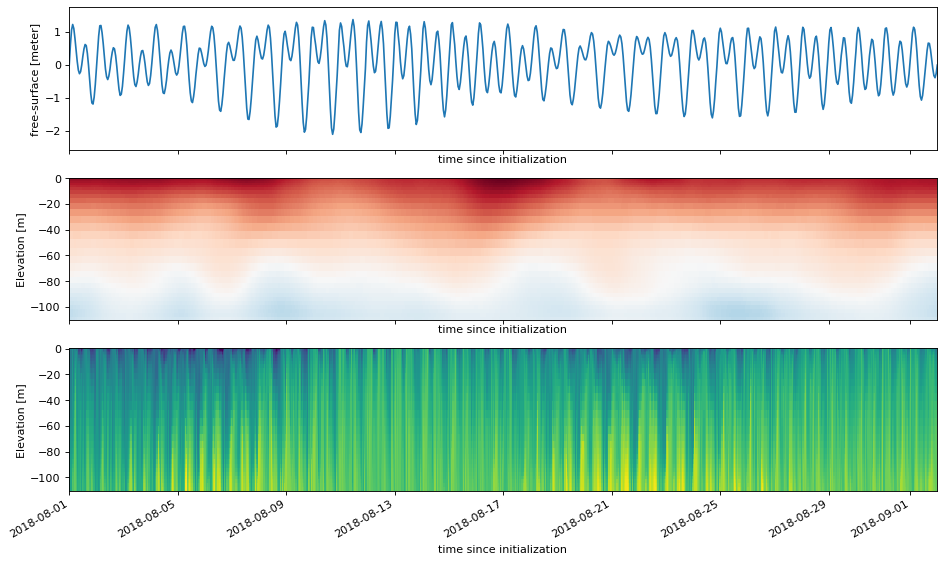

In [23]:
f = plt.figure(num=None, figsize=(14,8), dpi=80, facecolor='w', edgecolor='k')
(ax1, ax2, ax3) = f.subplots(3, 1, sharex=True)

plt.sca(ax1)
ds['zeta'].plot()  # Solution, remove before giving to students

plt.sca(ax2)
v_f_sum.plot(add_colorbar=False) # Solution, remove before giving to students

plt.sca(ax3)
salt_sum.plot(add_colorbar=False) # Solution, remove before giving to students


How did your answers to the questions hold up to the data? Now that you have looked closely at the tide, exchange velocity, and stratification by salinity. Summarize how the tides impact stratification and how stratification impacts exchange flow.

your answer here

### Going beyond

Make a 3-panel plot of tidal fluctuations (zeta), nitrate (NO3), and phytoplankton during the summer (July-August, as above). How do the Spring-Neap tidal cycles impact nitrate distributions and phytoplankton.


### An aside
Note that we are using the 'v' velocity, or the northward velocity. In both these cases the estuary is orientated predominantly towards the north, however in general, for such an analysis you need to first rotate into the principle flow direction using PCA. For our purproses, 'v', is sufficient